# Combine adiabatic master equation with spin-fluctuator model
In this example notebook, we solve the master equation of the following form
\begin{equation}
    \dot{\rho} = - i [-Z + \delta(s)Z, \rho] + \mathcal{L}(\rho)
\end{equation}
via trajectory method. In above expression, $\mathcal{L}$ is the Davies generator from adiabatic master equation. $\delta(s)$ is a classical stochastic process generated by summing multiple telegraph processes together:
\begin{equation}
    \delta(t) = \sum_{i=1}^N T_i(t) \ ,
\end{equation}
where $T_i(t)$ switches randomly between $\pm b_i$ with rate $\gamma_i$.

In [3]:
using OrdinaryDiffEq
using Plots
using QuantumAnnealingTools
using StatsBase

H = DenseHamiltonian([(s)->1.0], [-σz], unit=:ħ)
u0 = PauliVec[1][1]


coupling = ConstantCouplings(["Z"], unit=:ħ)
# number of fluctuators
num = 10
# The values of b created here are in angular frequencies unit
bvec = 0.01 * ones(num)
# γᵢ
γvec = log_uniform(0.01, 1, num)
# create the fluctuator coupling interaction
fluctuator_ensemble = EnsembleFluctuator(bvec, γvec);
interaction_fluctuator = Interaction(coupling, fluctuator_ensemble)
# create the Ohmic coupling interaction
ohmic_bath = Ohmic(1e-4, 4, 16)
interaction_ohmic = Interaction(coupling, ohmic_bath)
# merge those two bath object into `InteractionSet`
interactions = InteractionSet(interaction_fluctuator, interaction_ohmic)
annealing = Annealing(H, u0, interactions=interactions)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
u0 with size: (2,)

In [4]:
tf = 100
prob = build_ensembles(annealing, tf, :ame, ω_hint = range(-2, 2, length=100));

In [7]:
s_list = range(0,tf,length=200)
sol = solve(prob, Tsit5(), EnsembleSerial(), trajectories=1000, reltol=1e-6, saveat=s_list);

In [14]:
dataset = []
st(s, so) = normalize(so(s, continuity=:left))
for s in s_list
    push!(dataset, [real(st(s, so)' * σx * st(s, so)) for so in sol])
end

pop_mean = []
pop_rmse = []
for data in dataset
    p_mean = sum(data)/1000
    p_rmse = sqrt(sum((x)->(x-p_mean)^2, data))/1000
    push!(pop_mean, p_mean)
    push!(pop_rmse, 2*p_rmse)
end

We also solve the dynamics with pure Ohmic bath, i.e. the adiabatic master equation.

In [21]:
a_list = range(0,tf,length=400)
annealing_ame = Annealing(H, u0, coupling=coupling, bath=ohmic_bath)
sol_ame = solve_ame(annealing_ame, tf, alg=Tsit5(), ω_hint = range(-2, 2, length=100), 
    reltol=1e-6, saveat=a_list);

In [22]:
ame_x = [real(tr(u*σx)) for u in sol_ame.u];

We compare the $\langle X \rangle$ for those different noise models during the evolution.

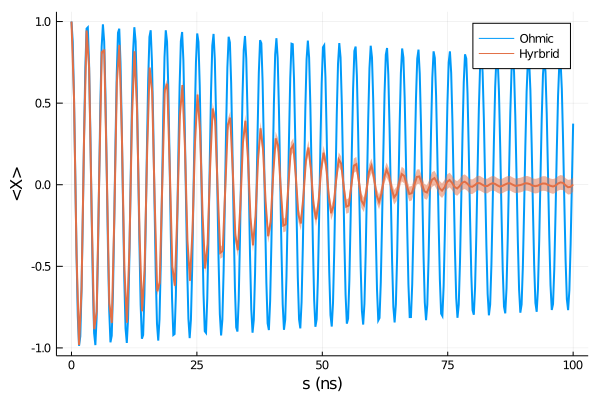

In [27]:
plot(a_list, ame_x, label="Ohmic", linewidth=2)
plot!(s_list, pop_mean, ribbon=pop_rmse, label="Hyrbrid", linewidth=2)
xlabel!("s (ns)")
ylabel!("<X>")